In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("data/final_dataset.csv")
print(df.shape)
df.head()


(12794627, 85)


,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,624,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:32 AM,3974862,29,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,625,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:36 AM,63,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,626,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:36 AM,476078,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,627,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:37 AM,151,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,628,192.168.4.118-203.73.24.75-4506-80-6,192.168.4.118,4506,203.73.24.75,80,6,12/06/2010 08:34:37 AM,472507,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [3]:
df.info()
df["Label"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12794627 entries, 0 to 12794626
Data columns (total 85 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Flow ID            object 
 2   Src IP             object 
 3   Src Port           int64  
 4   Dst IP             object 
 5   Dst Port           int64  
 6   Protocol           int64  
 7   Timestamp          object 
 8   Flow Duration      int64  
 9   Tot Fwd Pkts       int64  
 10  Tot Bwd Pkts       int64  
 11  TotLen Fwd Pkts    float64
 12  TotLen Bwd Pkts    float64
 13  Fwd Pkt Len Max    float64
 14  Fwd Pkt Len Min    float64
 15  Fwd Pkt Len Mean   float64
 16  Fwd Pkt Len Std    float64
 17  Bwd Pkt Len Max    float64
 18  Bwd Pkt Len Min    float64
 19  Bwd Pkt Len Mean   float64
 20  Bwd Pkt Len Std    float64
 21  Flow Byts/s        float64
 22  Flow Pkts/s        float64
 23  Flow IAT Mean      float64
 24  Flow IAT Std       float64
 25  Flow IAT Max    

Label
ddos      6472647
Benign    6321980
Name: count, dtype: int64

Drop Non-Numeric Columns

In [4]:
drop_cols = [
    'Unnamed: 0',
    'Flow ID',
    'Src IP',
    'Dst IP',
    'Timestamp'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])
print(df.shape)


(12794627, 80)


Handle Inf / NaN

In [5]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print(df.shape)


(12746847, 80)


In [6]:
df = df.sample(n=10000, random_state=42)


Feature / Label Split

In [7]:
X = df.drop("Label", axis=1).values
y = pd.factorize(df["Label"])[0]


In [8]:
import torch
import torch.nn as nn
from backend.model import CNN, osr_decision

In [9]:
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)


Load Saved Model

In [10]:
model = CNN(X_tensor.shape[2])
model.load_state_dict(torch.load("saved_model/cnn_model.pth", map_location="cpu"))
model.eval()


CNN(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=576, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

Predictions

In [11]:
predictions = []

with torch.no_grad():
    for i in range(len(X_tensor)):
        outputs, features = model(X_tensor[i:i+1])
        pred = torch.argmax(outputs, dim=1).item()
        predictions.append(pred)


Accuracy, Precision, Recall, F1

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y, predictions))
print("Precision:", precision_score(y, predictions, average="weighted"))
print("Recall:", recall_score(y, predictions, average="weighted"))
print("F1 Score:", f1_score(y, predictions, average="weighted"))


Accuracy: 0.5065
Precision: 0.25654224999999997
Recall: 0.5065
F1 Score: 0.3405804845668769


c:\Users\aldri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Confusion Matrix

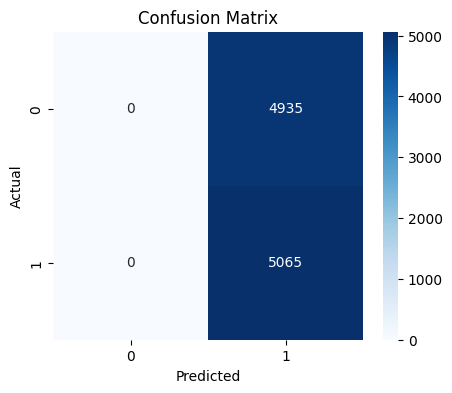

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, predictions)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


OPEN-SET (UNKNOWN ATTACK) TESTING

In [14]:
class_centers = [
    torch.zeros(64),
    torch.ones(64)
]

unknown_count = 0

with torch.no_grad():
    for i in range(len(X_tensor)):
        _, features = model(X_tensor[i:i+1])
        pred, dist = osr_decision(features[0], class_centers)

        if pred == "Unknown DDoS":
            unknown_count += 1

print("Unknown samples detected:", unknown_count)


Unknown samples detected: 10000
